In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import stats
from collections import deque
from scipy.optimize import minimize
from scipy.linalg import norm, inv, det
import time
import seaborn as sns
sns.set_theme()
#sns.set(font_scale=3)

In [2]:
mu = np.array([[1.0],
               [1.0]])

alpha = np.array([[0.5, 0.0],
                  [0.4, 0.4]])

beta = np.array([[1.0],
                 [1.3]])

noise = 0.5

print("Spectral radius:", np.max(np.abs(np.linalg.eig(alpha)[0])))

Spectral radius: 0.5


In [3]:
theta_reduced = np.concatenate((mu.ravel(), alpha.ravel(), beta.ravel(), np.array([noise])))
theta_full = np.concatenate((mu.ravel(), (alpha[alpha > 0.0]).ravel(), beta.ravel(), np.array([noise])))
theta_reduced, theta_full

(array([1. , 1. , 0.5, 0. , 0.4, 0.4, 1. , 1.3, 0.5]),
 array([1. , 1. , 0.5, 0.4, 0.4, 1. , 1.3, 0.5]))

In [4]:
import pickle
with open('saved_estimations/estimationsColumn.pkl', 'rb') as file:
    _, est_colmax, est_col = pickle.load(file)
with open('saved_estimations/estimationsTriangle.pkl', 'rb') as file:
    _, est_trimax, est_tri = pickle.load(file)

In [5]:
theta_col = np.array([1. , 1. , 0.5, 0.4, 1. , 1.3, 0.5])
theta_tri = np.array([1. , 1. , 0.5, 0.4, 0.4, 1. , 1.3, 0.5])

theta_colfull = np.array([1. , 1. , 0.5, 0.0, 0.4, 0.0, 1. , 1.3, 0.5])
theta_trifull = np.array([1. , 1. , 0.5, 0.0, 0.4, 0.4, 1. , 1.3, 0.5])

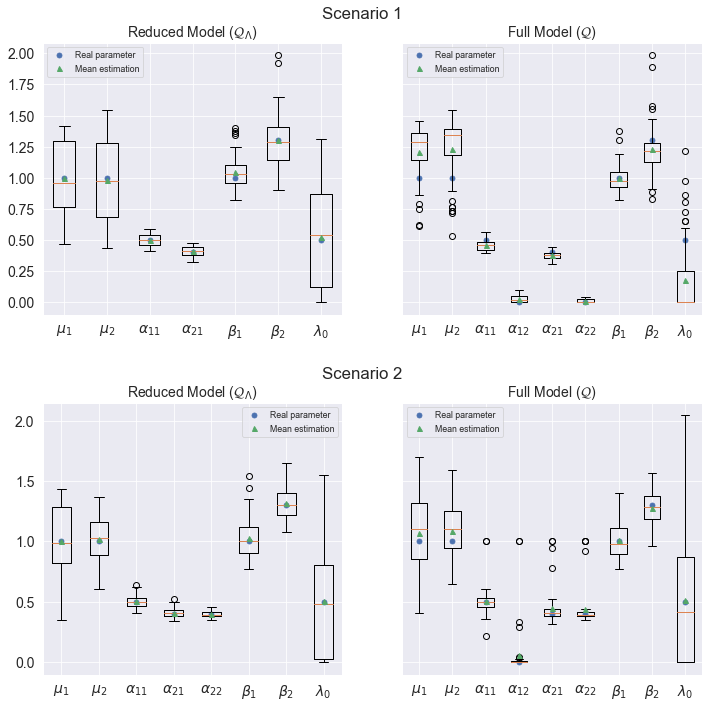

In [33]:
parameters_col = [r"$\mu_1$", r"$\mu_2$", r"$\alpha_{11}$", r"$\alpha_{21}$", r"$\beta_1$", r"$\beta_2$", r"$\lambda_0$"]
parameters_tri = [r"$\mu_1$", r"$\mu_2$", r"$\alpha_{11}$", r"$\alpha_{21}$", r"$\alpha_{22}$", r"$\beta_1$", r"$\beta_2$", r"$\lambda_0$"]
parameters_full = [r"$\mu_1$", r"$\mu_2$", r"$\alpha_{11}$", r"$\alpha_{12}$", r"$\alpha_{21}$", r"$\alpha_{22}$", r"$\beta_1$", r"$\beta_2$", r"$\lambda_0$"]

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14, 'xtick.labelsize': 14,'ytick.labelsize': 14})   
fig, ax = plt.subplots(2, 1, figsize=(5.90666*2,10), sharey=True)
for axs in ax:
    axs.remove()

gridspec = ax[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

estimations_list = [[est_colmax, est_col], [est_trimax, est_tri]]
parameters_list = [[theta_col, parameters_col, theta_colfull], [theta_tri,parameters_tri, theta_trifull]]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(f"Scenario {row + 1}")
    
    ax = subfig.subplots(1, 2, sharey=True)
    bp = ax[0].boxplot(estimations_list[row][0], showmeans=True, meanprops={"markersize":5})
    rp = ax[0].scatter(range(1, len(parameters_list[row][0])+1), parameters_list[row][0], label="Real parameter", s=5**2)

    ax[0].set_xticklabels(parameters_list[row][1])
    ax[0].legend([rp, bp['means'][0]], ['Real parameter', 'Mean estimation'], loc='best')
    ax[0].set_title(r"Reduced Model ($\mathcal{Q}_\Lambda$)")
    
    bp = ax[1].boxplot(estimations_list[row][1], showmeans=True, meanprops={"markersize":5})
    rp = ax[1].scatter(range(1, 10), parameters_list[row][2], label="Real parameter", s=5**2)

    aux = np.max(est_col[est_col[:, -2] < np.max(est_col[:, -2]), -2])
    #ax[1].set_ylim([0.0 - 0.05 * aux, 
    #             1.05 * aux])
    ax[1].set_xticklabels(parameters_full)
    ax[1].legend([rp, bp['means'][0]], ['Real parameter', 'Mean estimation'], loc='best')
    ax[1].set_title(r"Full Model ($\mathcal{Q}$)")



fig.savefig("bivariate_images/column_triangle_model_estimation.pdf", format="pdf", bbox_inches="tight")


# Error by parameter vector

In [59]:
def norms(v, sizes):
    aux = 0
    res = np.zeros(len(sizes))
    for i, idx in enumerate(sizes):
        res[i] = norm(v[aux:aux+idx], ord=1)
        aux += idx
    return res

[[[0.274 0.3  ]
  [0.018 0.01 ]
  [0.019 0.441]]

 [[0.086 0.132]
  [0.002 0.003]
  [0.01  0.104]]

 [[0.116 0.108]
  [0.006 0.005]
  [0.048 0.075]]

 [[0.749 0.853]
  [0.155 0.089]
  [0.022 0.325]]]


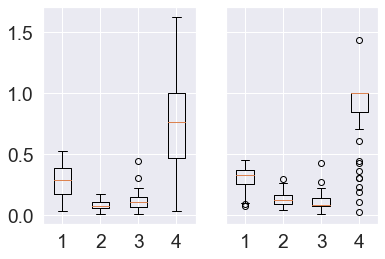

In [60]:
# Errors for Column (Rows: MSE, Std, Error on average estimation) (Column: Reduced, Full)
fig, ax = plt.subplots(1,2, sharey=True)
mat = np.zeros(((4, 3 ,2)))
norm_theta = norms(theta_col, [2,2,2,1])
i=0
ests = [est_colmax, est_col]
thets = [theta_col, theta_colfull]
ids = [2,4]
for i in range(2):
    errors = ests[i] - thets[i]
    errors = np.array([norms(j, [2,ids[i],2,1]) for j in errors])/norm_theta
    _ = ax[i].boxplot(errors)
    mean_error = np.mean(ests[i], axis=0) - thets[i]
    mat[:, 0, i] = np.round(np.mean(errors, axis=0),3)
    mat[:, 1, i] = np.round(np.std(errors, axis=0)**2,3)
    mat[:, 2, i] = np.round(norms(mean_error, [2,ids[i],2,1]),3)
print(mat)

[[[0.21  0.231]
  [0.016 0.015]
  [0.024 0.155]]

 [[0.075 0.204]
  [0.002 0.19 ]
  [0.018 0.149]]

 [[0.105 0.1  ]
  [0.005 0.004]
  [0.046 0.031]]

 [[0.762 0.889]
  [0.244 0.338]
  [0.009 0.018]]]


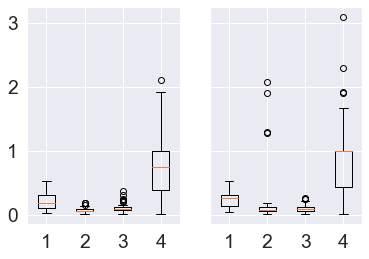

In [61]:
# Errors for Triangle (Rows: MSE, Std, Error on average estimation) (Column: Reduced, Full)
mat = np.zeros((4,3,2))
fig, ax = plt.subplots(1,2, sharey=True)
norm_theta = norms(theta_tri, [2,3,2,1])
i=0
ests = [est_trimax, est_tri]
thets = [theta_tri, theta_trifull]
ids = [3,4]
for i in range(2):
    errors = ests[i] - thets[i]
    errors = np.array([norms(j, [2,ids[i],2,1]) for j in errors])/norm_theta
    _ = ax[i].boxplot(errors)
    mean_error = np.mean(ests[i], axis=0) - thets[i]
    mat[:, 0, i] = np.round(np.mean(errors, axis=0),3)
    mat[:, 1, i] = np.round(np.std(errors, axis=0)**2,3)
    mat[:, 2, i] = np.round(norms(mean_error, [2,ids[i],2,1]),3)
print(mat)
    